<a href="https://colab.research.google.com/github/andylynchul/CE6003/blob/main/Week%202/CE6003_20208189__Etivity_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etivity 2: Deep Convolutional Neural Network on CIFAR-10 Dataset

In this assignment, we will gain some practical experience of coding a deep convolutional neural network in Tensorflow. The simplest way to code a network is to use the High level Keras API within Tensorflow 2.5.  

## (a) Introduction

 In this assignment to reduce training time and computation, we will train our network using the simple [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
![link text](https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

The goal of this Etivity is to build and train your own Deep Convolutional Neural Network. This notebook contains standard keras/Tensorflow code to perform data processing, training set up and testing metrics, as outlined in the steps below. This will allow you to focus on developing the architecture & code for your network. 

1. Load Dataset - We will import the CIFAR-10 Dataset using the Tensorflow Data Set API.
2. Prepare Data - We will slightly modify the dataset before it is sent to the model for training.
3. Model Coding - We will write code to build the model using the Tensorflow keras API.
  * **You will code your neural network model in this section**
4. Compile Model - We will complile the model and verify that it has been correctly constructed.
5. Train Model - We will train the model using the imported dataset.
6. Test Model - We test the model on the training data and obtain a classification report and confusion matrix.

The principal resource for understanding the basics of how to code & train Deep Convolutional Neural Network architectures in Tensorflow/keras are the Tensorflow tutorials. Tutorials on [image classification](https://www.tensorflow.org/tutorials/images/classification) and [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) are useful for this Etivity.  


## (b) Notes on Architecture selection & development

A key task in this Etivity is selecting an appropriate architecture. You can base your archicture on any of the types seen in the lecture notes or published literature. It is however recommended to ensure you can get a standard CNN type architecture to successfully train before attempting a more complex architecture or adding further enhancements to your network to improve performance.
   Many published networks are designed to work with larger sized input images (e.g. 224 x 224). Often large (e.g. 7 x 7) convolution kernels and pooling layers are first applied to the input image, which agressively reduce the spatial dimensions of the network. As the CIFAR-10 dataset only has 32 x 32 images, it is recommended that just an intial 3 x 3 convolution is applied to the input image (as shown in the figure below), which will preserve the spatial dimensions of the input, before any other layers are added. It is expected that as you add more layers to the network the spatial dimensions will reduce and there will also be a corresponding increase the number of channels of the output feature map. The architecture will end with a [global average pooling layer](https://arxiv.org/pdf/1312.4400.pdf) and a fully-connected layer (called a *dense* layer in Keras/Tensorflow) with softmax activation which gives us our 10 class predictions. A skeleton code has been provided for any general architure using this structure in section 3.
![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/Architecture_outline.jpg?raw=true)


# Information on Load Dataset

In this assignment, we will be using the [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.htmlhttps://). CIFAR-10 is often used as a "Hello World" dataset that is often used to ensure a network architecture is working before moving on to training with more complex datasets.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes (airplane, automobile, **bird**, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class. There are 50,000 training images and 10,000 test images. 

We will use the [Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10) API to download the CIFAR10 dataset.

# Library Setup & Imports

In [51]:
from __future__ import print_function

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Input, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report


# Added by me
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.datasets import cifar10 
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from google.colab import files
from PIL import Image
from io import BytesIO
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np

# Global Variable Store

In [5]:
# Globals
batch_size = 32 # Default Batch size (can be adjusted)
H_trg =32       # Image Height (fixed)
W_trg =32       # image Width (fixed)

# Labels corresponding to categories
label_str = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Global Function Store

In [6]:
# Functions
def load_data():
    # Function to laod Data set
    ds,info= tfds.load("cifar10",with_info=True)

    raw_train = tfds.load('cifar10', split='train[0%:90%]')
    raw_val = tfds.load('cifar10', split='train[91%:100%]')
    raw_test = tfds.load('cifar10', split='test')

    return raw_train, raw_val, raw_test

# alternative method to load the data.
def load_data_alt():
    # load dataset
    (train_X, train_Y), (testX, testY) = cifar10.load_data()
    
    # generate Training & Validation set
    trainX, validateX, trainY, validateY = train_test_split(train_X, train_Y, train_size=0.8)
    
    # one hot encode target values
    trainY = to_categorical(trainY)
    validateY = to_categorical(validateY)
    testY = to_categorical(testY)
    
    return trainX, trainY, validateX, validateY, testX, testY

# original data_pipe to convert pixels to floats to allow normalisation
def data_pipe(image,label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = image-0.5
    label = tf.cast(label, tf.float32)
    return image,label

# update data_pipe to convert pixels to floats to allow normalisation
def images_prep(train,val,test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    val_norm = val.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    val_norm = val_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, val_norm, test_norm

# prepa single image for classification
def image_prep(filename):
    # load the image (using lib defined above)
    img = load_img(filename, target_size=(H_trg, W_trg))
    # convert to array (using lib defined above)
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 32, 32, 3)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.

    return img

# visulaise the confusion matrix for testing routine
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot diagnostic learning curves
def summarize_diagnostics(history):
    print(history.history.keys())
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


# Model Definition & Compilation

Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. We define  loss function, the optimizer and metrics. 

In [55]:
# Model Definition
def define_model():
    model = Sequential()
    
    #data augmentaton - this embeds pre-processing in the model. better to apply to the data
    #model.add(layers.RandomFlip())
    #model.add(layers.RandomRotation(0.2))

    #layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    #layer 2
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    #layer 2
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    #layer 3
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # flatten
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # compile model
    # opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

In [56]:
# Model Definition
def define_model_new():
    model = Sequential()
    
    # Conv => MaxPool
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Conv => MaxPool
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Conv => MaxPool
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # FC => SoftMax
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))

    # set callbacks
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    # compile model
    # opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], callback=[es,mc])

    model.summary()

    return model

# Model Training Regime

We will now train the complied model on the cifar10 dataset using the tensorflow keras `model.fit` method. 



In [15]:
# Model Training Regime
def train_model(epochs_n=10, batch_size_n=64, save_model=False, aug=False):
		# load dataset
		trainX, trainY, valX, valY, testX, testY = load_data_alt()
		# prepare pixel data
		trainX, valX, testX = images_prep(trainX, valX, testX)
		# define model
		model = define_model()

		if aug:
			# create data generator
			# datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	 		datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, shear_range=0.2, zoom_range=0.3, horizontal_flip=True)
			# prepare iterator
			it_train = datagen.flow(trainX, trainY, batch_size=batch_size_n)
			# fit model
			steps = int(trainX.shape[0] / batch_size_n)
			
			history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs_n, validation_data=(valX, valY), verbose=1)
		else:
			# fit model
			history = model.fit(trainX, trainY, epochs=epochs_n, batch_size=batch_size_n, validation_data=(valX, valY), verbose=1)
		
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=2)
		# save model if final
		if save_model:
			model.save('final_model.h5')
		#print accuracy
		print('> %.3f' % (acc * 100.0))
		# learning curves
		summarize_diagnostics(history)

# Model Fitness Test

We will iterate through the test data and analyse the results using tools from sklearn. We create a classification report, a confusion matrix and also plot a few examples from the test set.

In [9]:
# Test Model
def test_model(model, confusion=True, summary=True, plots=True):
    n_test = 100 # number of batches to use
    store_predictions = []
    store_labels = []
    for image_batch,label_batch in test_dataset.take(n_test):
      predictions = model.predict_on_batch(image_batch) 
      predictions = tf.math.argmax(predictions,axis=1)
      store_predictions.append(predictions)
      store_labels.append(label_batch)
    y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
    y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))

    if confusion:
      # Generate Confusion Matrix
      cm = confusion_matrix(y_true, y_pred)
      # Visualise Confusion Matrix
      print(plot_confusion_matrix(cm))
      print("\n\n")

    if summary:
      # Generate Classification Report
      print(classification_report(y_true, y_pred, target_names=label_str) + "\n\n")

    if plots:
      #Retrieve a batch of images from the test set
      image_batch, label_batch = test_dataset.as_numpy_iterator().next()
      predictions = model.predict_on_batch(image_batch)
      #print(np.shape(predictions))
      # Apply a sigmoid since our model returns logits
      predictions = tf.math.argmax(predictions,axis=1)
      #print(np.shape(predictions))
      #print('Predictions:\n', predictions.numpy())

      i=0
      n_plots = 12 # number of plots
      f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

      for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
        axarr[i].imshow(image[:,:,:]+0.5)
        axarr[i].axis('off')
        
        color = ('black' if predictions[i] == int(label_batch[i]) else 'red') 
        axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
        i = i+1


# Live Image Classifier

In [10]:
# Test image on Final Model
def classify_image(model):
    # allow user to uplaod images
    uploaded = files.upload()
    #test_img_prepped = image_prep(test_img)
    for fn in uploaded.keys():
      test_img = image_prep(fn)
      # predict the class
      y_pred = model.predict(test_img)
      y_pred = np.round(y_pred).astype(int)

      show_img = Image.open(BytesIO(uploaded[fn]))

      plt.imshow(show_img)
      plt.show() 
      
      print("We think this is of class : ",label_str[np.argmax(y_pred[0])])

# Train Model

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_144 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_105 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_142 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_106 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_143 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 16, 16, 32)      

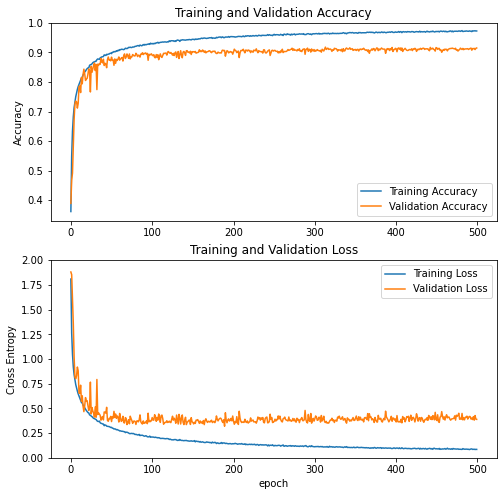

In [57]:
train_model(epochs_n=500, batch_size_n=64, save_model=True, aug=True)

# Test Model

# Classify Image

Saving bird1.png to bird1.png


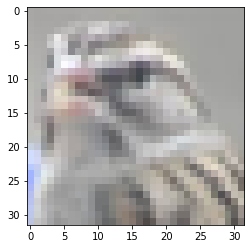

We think this is of class :  bird


In [ ]:
model_to_classify = load_model('final_model.h5')
classify_image(model_to_classify)

--------------------------------------------------------------------------------



 
## Note 1: Keras Function/Sequential API

Within Keras there are two API's for coding network models: Sequential and functional. You may have already used the [seqential model](https://https://www.tensorflow.org/guide/keras/sequential_model) to code basic artifical neural networks. The [functional model](https://www.tensorflow.org/guide/keras/functional) is more general and enables us to include feedforward paths which are required to code more advanced networks such as ResNet or DenseNet. The functional API has been used to code the helper functions repeating unit/top level skeleton detailed below.

## Note 2: Repeating Unit

In many Deep architectures there will often be a repeating unit(s) that is composed of a sequence of layers, for example Conv,ReLU & Batch Normalisation. Specific layers can be turned on or off as required. This also allows experimentation of the entire architecture with/without specific layers (e.g. Batch Normalisation)  You may wish to create other combinations of layers or additional repeating units depending on your architecture.

In the code cell below we can see an example of a `repeat_unit` function where the number of kernel filters and kernel size is specified. Batch Normalisation and activation layers can be turned on/off as required.

 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 
 * Batch Normalization layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) 
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) 
 

In [ ]:
# Example of a Basic Repeating unit

def repeat_unit(inputs, num_channels=16, kernel_size=3,
                 strides=1, activation='relu', batch_normalization=False):
    """
    inputs: Input to repeat unit.
    num_channels: number of channels in convolution layer of repeat unit, nominally = 16
    kernel_size: number of kernels to use in convolution, nominally = 3
    strides: number of strides for kernel, nominally = 1
    activation: type of activation applied to output of convolution, nominally ReLU. 
    x = output of repeat_unit
    """
    conv = Conv2D(num_channels, kernel_size=kernel_size, strides=strides, padding='same',
                  kernel_initializer='he_normal')
    
    x = conv(inputs)
    
    if activation is not None:
        x = Activation(activation)(x)

    if batch_normalization:
        x = BatchNormalization()(x)

    return x


## Note 3: Top Level

In the code cell below, an incomplete skeleton function is provided for your top level.  
* This uses the Keras functional API
* A single repeating unit which does not reduce the spatial dimensions of the input is placed at the top of the stack. You can change the number of channels/kernel size to suit your own architecture.
* You can add your own layers/repeating units etc to build your own architecture with the function.
* At the end of the stack we add a [global average pooling layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and fully connected [(Dense)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation. (Alternatively to the Global Average pooling Dense layers can be used, this approach uses more parameter (memory) and is commonly seen in earlier Deeep Learning architectures such as AlexNet)

In [ ]:

def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset 
    model:       keras Model returned by this function.                          
    """
       
    # Define input of model
    inputs = Input(shape=input_shape)

    # Add First repeating Unit
    x = repeat_unit(inputs=inputs, num_channels=12)
  
   ######## Add more layers/repeating units to build your Architecture here ##################  


    # Add final stages. (Ensure that you call the output of the very last layer outputs)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    
    return model